# ResNet implementation in Keras

This is an unoffcial implementation of the ResNet in Keras (concept and architectue: https://arxiv.org/pdf/1512.03385.pdf).

This implementation alows in a fexible way to generate the ResNet 18 and 34 model variants.
Other ResNet configurations (like number of resnet blocks, or filter number) can be easily changed. 
Identity shortcuts on dimension transition use 1x1 convolution to match the desired output, see the paper for details.


Author: fvilmos
https://github.com/fvilmos




In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2

import os
import glob

USE_GPU = 1

if USE_GPU == 1:    
    configproto = tf.compat.v1.ConfigProto() 
    configproto.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=configproto) 
    tf.compat.v1.keras.backend.set_session(sess)

    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True)

    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

Num GPUs Available:  1


## Create a toy database

- Input is a pair of images (128x128x3)
- n samples are generated (rectangles/circles, triangles with different size, colors)
- background noice added to increase the detection difficulty

In [2]:
BATCH_SIZE = 8
samples = 10000
w,h = 128,128
img_channels = 3
obj_min_size = 15
obj_max_size = 70
nr_shape_type = 3
nr_shape_color = 6
stype_lab = ['circle','rectangle', 'triangle']
scolor_lab = ['Red','Green','Blue','Yellow','Pink', 'Cyan']
colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255]]

In [3]:
def toCategorical(val,size):
    '''
    transform the values to cathegorical
    '''
    s_list = [0 for _ in range(size)]
    s_list[val] = 1
    return np.array(s_list)

def generate_blur(img, iw=128,ih=128):
    """
    generate a blury background for an image
    """
    samples = (np.random.random(size=(iw,ih,3)) *1000).astype(np.ubyte)
    b_kernel = np.dot(np.random.choice([3,5,7,9,11,13,17]),np.array([1,1]))

    samples = cv2.blur(samples,tuple(b_kernel))
    img +=samples
    
    return img

# test image generator
def generate_img_with_shape(img, shape_type=0, color=(0,255,0), img_shape=(128,128), obj_size=(30,60)):
    """
    generate an image with a shape type
    0 - circle, 1 - retangle , 2 - triangle
    """

    ow = np.random.randint(obj_size[0],obj_size[1],dtype=np.uint8)
    oh = np.random.randint(obj_size[0],obj_size[1],dtype=np.uint8)
    oposx = np.random.randint(int(ow/2),img_shape[0]-ow,dtype=np.uint8)
    oposy = np.random.randint(int(oh/2),img_shape[1]-oh,dtype=np.uint8)

    if shape_type == 0:
        r = int(min(ow/2,oh/2))
        cv2.circle(img,(oposx,oposy),r,color,-1)
    elif shape_type == 1:
        cv2.rectangle(img,(oposx,oposy),(oposx+ow,oposy+oh),color,-1)
    elif shape_type == 2:
        triangle_points= np.array([[oposx,oposy],[oposx+ow,oposy],[oposx,oposy+oh]],dtype=np.int32)
        cv2.drawContours(img, [triangle_points], 0, color, -1)
        flipc = np.random.randint(-2,2,dtype=np.int8)
        img = cv2.flip(img,flipc)
    return img



def gen_traning_data(samples_nr=1000, iw=128,ih=128,obj_min=30,obj_max=60,nr_classes=3):
    """ 
    generate traning data - rectangles with different size, return img and position
    """
    
    img = np.zeros((samples_nr,iw,ih,3),dtype=np.uint8)
    img_labels = np.zeros((samples_nr,nr_classes),dtype=np.uint8)
 
    # generate random samples
    for i in range (samples_nr):

        samples = np.zeros(shape=(iw,ih,3),dtype=np.uint8)
        
        img[i] += generate_blur(samples, iw,ih)

        shape_type = np.random.randint(0,3,dtype=np.uint8)

        # generate random between [0,5]
        clord = np.random.randint(0,6,dtype=np.uint8)
        color = colors[clord]

        img[i] = generate_img_with_shape(img[i],shape_type=shape_type, color=color)
        
        cat_val = toCategorical(shape_type,nr_classes)
        img_labels[i] = np.array(cat_val)

    return img, img_labels


In [4]:
class DataLoader(keras.utils.Sequence):
    """
    Dataset generator
    """
    def __init__(self, batch_size, sample_nr=1000, img_size=(128,128,3), obj_min=15, obj_max=75):
        self.batch_size = batch_size
        self.sample_nr=sample_nr
        self.img_size=img_size
        self.obj_max = obj_max
        self.obj_min = obj_min
    
    def __len__(self):
        return self.sample_nr//self.batch_size
    
    def __getitem__(self, indx):
        # simplified version, generates random samples by every call
        img,labels = gen_traning_data(samples_nr= self.batch_size,iw=self.img_size[0],ih=self.img_size[1],obj_min=self.obj_min,obj_max=self.obj_max)
        
        return {'data_in':img},{'data_out':labels}

train_data = DataLoader(BATCH_SIZE,samples, obj_min=obj_min_size, obj_max=obj_max_size, img_size=(w,h))
val_data = DataLoader(BATCH_SIZE,int(samples*0.2),obj_min=obj_min_size, obj_max=obj_max_size, img_size=(w,h))
tst_data = DataLoader(BATCH_SIZE,int(samples*0.05),obj_min=obj_min_size, obj_max=obj_max_size, img_size=(w,h))

print ("Samples shape: ", train_data[0][0]['data_in'].shape, "Labels:",train_data[0][1]['data_out'].shape)


Samples shape:  (8, 128, 128, 3) Labels: (8, 3)


## Plot some samples from the dataset

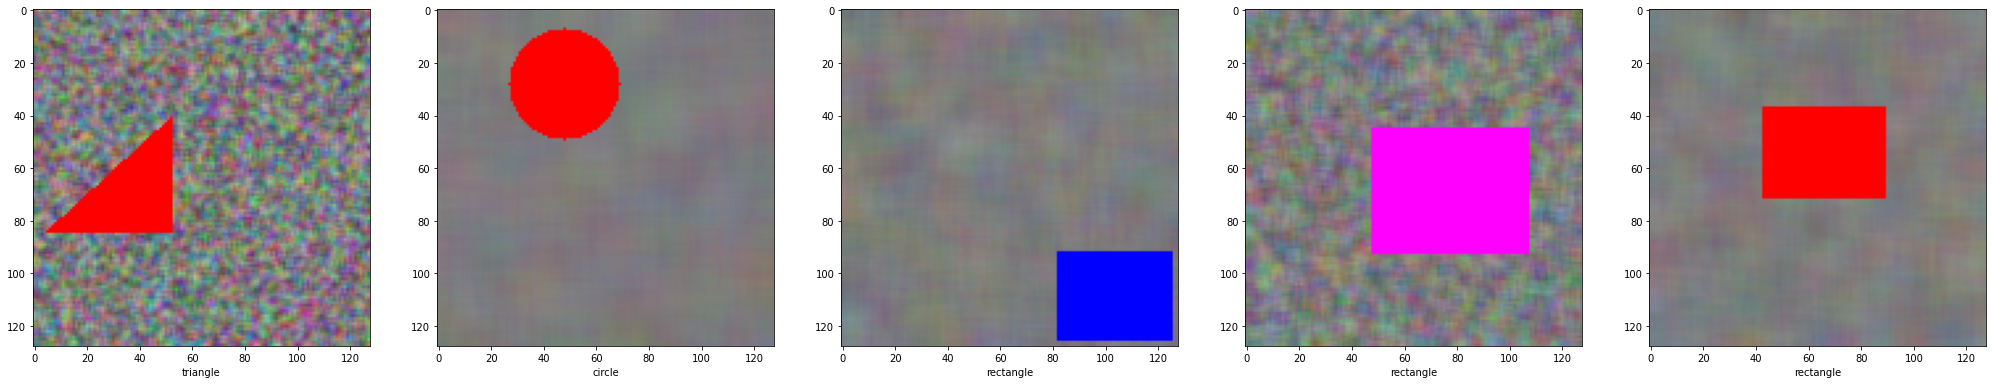

In [5]:
def plot_data(imgarrl,imglabels):
    #plot image, plt keypoints
    plt.rcParams["figure.figsize"] = (35,12)
    # draw a array of plots
    fig, axs = plt.subplots(1, len(imgarrl))
    for i in range(len(axs)):
        axs[i].set_xlabel(str(str(stype_lab[np.argmax(imglabels[i])])))
        axs[i].imshow(imgarrl[i])

# draw n samples
tmp_data = train_data[0]

plot_data(tmp_data[0]['data_in'][:5], tmp_data[1]['data_out'][:5])

## Create a fuctional keras model


## Create the ResNet network

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           batch_normalization[0][0]        
_____________________________________________________________________________________________

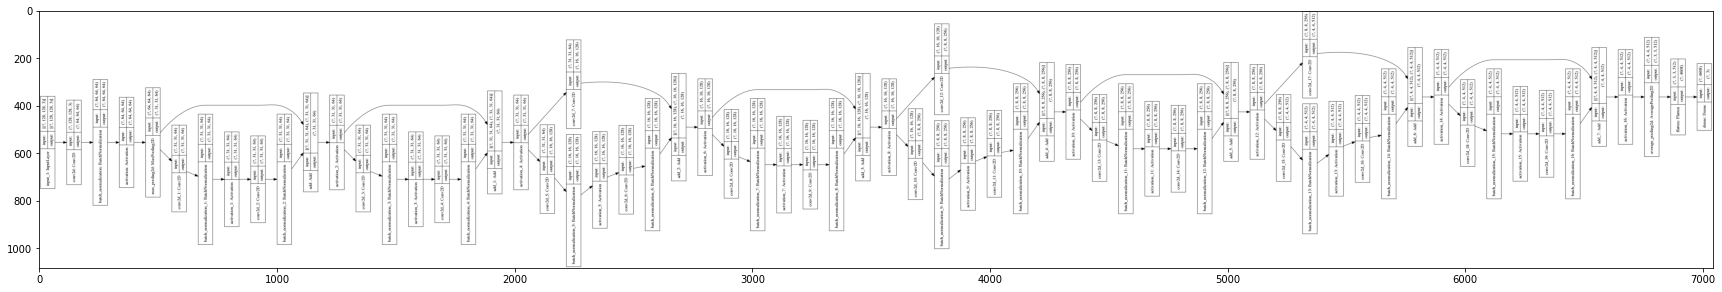

In [6]:
def residual_conv(data, filter_nr,kernel_size,strides,padding="SAME", activation='relu'):
    '''
    residual convolution block, with selectable activation
    '''
    y = keras.layers.Conv2D(filter_nr,kernel_size,strides,padding="SAME")(data)
    y = keras.layers.BatchNormalization()(y)
    
    if activation != '':
        y = keras.layers.Activation(activation)(y)
    return y

def residual_combine(data_in, data_in1):
    '''
    cobine 2 outputs
    '''
    y  = keras.layers.Add()([data_in,data_in1])
    y = keras.layers.Activation('relu')(y)
    return y
    
def residual_block(data,kernel_size=(3,3),filter_nr=64, strides=(2,2)):
    '''
    cobine the residual block to obtain the residual processing block
    '''
    y = residual_conv(data,filter_nr,kernel_size,strides,padding="SAME")
    y = residual_conv(y,filter_nr,kernel_size,strides=(1,1),padding="SAME",activation='')
            
    # use identity shortcuts - if input /output has the same dimensions else downside it 
    if strides[0]!=1:
        data = keras.layers.Conv2D(filters=filter_nr,kernel_size=(1,1), strides=(2,2), padding="SAME")(data)
    
    out = residual_combine(data, y)

    return out

def res_net(net_shape=(128,128,3), filter_list=[2],block_list=[64], kernel_size=(3,3), strides=(1,1), output=3):
    '''
    Create the ResNet structure
    '''
    #input layer
    data = keras.Input(shape=net_shape)
    
    # conv1 layer
    y = residual_conv(data,filter_nr=filter_list[0],kernel_size=(7,7),strides=(2,2))
    y = keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2))(y)

    # create the network, conv2_x...conv5_x layers
    for i in range (len(block_list)):
        for j in range(block_list[i]):
            y = residual_block(y,filter_nr=filter_list[i], kernel_size=(3,3),strides=(2,2) if j==0 and i!=0 else (1,1))
    
    y = keras.layers.AveragePooling2D(pool_size=(2,2), strides=(1,1))(y)
    y = keras.layers.Flatten()(y)
    
    # # output matched to the given classification problem
    out = keras.layers.Dense(output,activation='softmax')(y)
    
    # create the ResNet model
    model = keras.Model(inputs={"data_in":data}, outputs={"data_out":out}, name="ResNet")
    keras.utils.plot_model(model,to_file='./info/ResNet_model.png',show_shapes=True)
    
    return model


# ResNet18 configuration, see detial in the paper
# hols 4x2 residual_blocks, with 2x increasing filters, beginning from 64
block_list = [2,2,2,2]
filter_list = [64,128,256,512]

model = res_net(net_shape=(w,h,img_channels),filter_list=filter_list, block_list=block_list)
model.compile(keras.optimizers.Adam(1e-4),loss = keras.losses.CategoricalCrossentropy(), metrics=['mse','acc'])

img = plt.imread('./info/ResNet_model.png')
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imsave('./info/ResNet_model_90ccw.png', img)

plt.figure(figsize=(30,20))
plt.imshow(img)
print (model.summary())

## Train the model

In [7]:
epochs=50
steps=(samples//epochs)
valsteps= int(samples*0.1//epochs)

callbacks = [
    keras.callbacks.EarlyStopping(patience=3),
    keras.callbacks.ModelCheckpoint(filepath='resnet.h5',save_best_only=True,verbose=1),
]

hist = model.fit(x=train_data,validation_data = tst_data,steps_per_epoch=steps,validation_steps=valsteps, epochs=epochs, batch_size=8,callbacks=callbacks, verbose=1,shuffle=False)

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 1.2107 - mse: 0.1974 - acc: 0.5931
Epoch 00001: val_loss improved from inf to 0.81957, saving model to resnet.h5
200/200 [==============================] - 16s 81ms/step - loss: 1.2107 - mse: 0.1974 - acc: 0.5931 - val_loss: 0.8196 - val_mse: 0.1504 - val_acc: 0.6562
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5033 - mse: 0.0951 - acc: 0.8087
Epoch 00002: val_loss improved from 0.81957 to 0.18871, saving model to resnet.h5
200/200 [==============================] - 16s 82ms/step - loss: 0.5033 - mse: 0.0951 - acc: 0.8087 - val_loss: 0.1887 - val_mse: 0.0371 - val_acc: 0.9312
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.1282 - mse: 0.0232 - acc: 0.9531
Epoch 00003: val_loss improved from 0.18871 to 0.12476, saving model to resnet.h5
200/200 [==============================] - 16s 81ms/step - loss: 0.1282 - mse: 0.0232 - acc: 0.9531 - val_loss: 0.1248 - val_mse: 0.0


## Plot train information

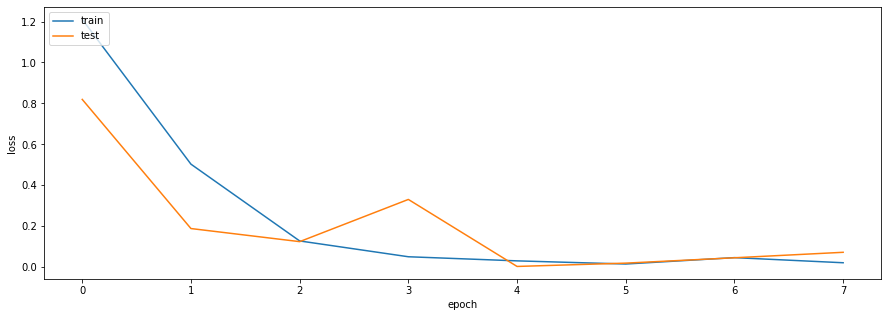

In [8]:
fig,axs = plt.subplots(figsize=(15, 5))
axs.set_xlabel("epoch")
axs.set_ylabel("loss")
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.legend(['train','test'], loc='upper left')

plt.show()


## Test the trained model

In [9]:
# load trained model
model = keras.models.load_model('resnet.h5')

tst_nr = 5
tst_img,tst_labels = gen_traning_data(samples_nr=tst_nr,iw=w,ih=h,obj_min=obj_min_size,obj_max=obj_max_size)


# normalize images
tst_X = (tst_img.reshape(tst_nr,-1))
tst_X = tst_X.reshape(len(tst_X),128,128,3)

# evaluate the model
print("Model performace on test data...\n")
results = model.evaluate(x={'data_in':tst_X},y={'data_out':tst_labels}, batch_size=1)
print("test loss, test acc:", results, "\n")

Model performace on test data...

5/5 [==============================] - 0s 9ms/step - loss: 2.3035e-04 - mean_squared_error: 1.1174e-07 - acc: 1.0000
test loss, test acc: [0.00023034701007418334, 1.1173932534802589e-07, 1.0] 



## Test detections

Predicted label: circle


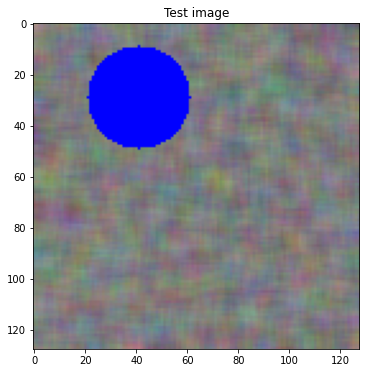

In [10]:
# create the compare image, and show
img = np.zeros(shape=(128,128,3),dtype=np.uint8)
img = generate_blur(img)

stype = np.random.randint(0,3,dtype=np.uint8)
clord = np.random.randint(0,6,dtype=np.uint8)
color = colors[clord]

test_img = generate_img_with_shape(img,shape_type=stype, color=color)

# test
res = model.predict(x={'data_in':np.array([test_img])}, batch_size=1)

# search for the max value
ret_val = np.argmax(np.array(res['data_out']))
print ("Predicted label:",stype_lab[int(ret_val)])
plt.figure(figsize=(12,6))
plt.imshow(test_img)
plt.title('Test image')
plt.show()

### References
1. [Deep Residual Learning for Image Recognition, Kaiming He, et all](https://arxiv.org/pdf/1512.03385.pdf)